# Markov Switching Model

For this assignment we will try to explain the evolution of the crude oil stock  price (**CL=F**) with these following exogeneous variables: 

* US GDP Growth (**GDP**)
* Industrial Production: Mining, Quarrying, and Oil and Gas Extraction: Crude Oil (**IPG211111CS**)
* Crude Oil Production for Saudi Arabia (**SAUNGDPMOMBD**)	
* Crude Oil Production for United Arab Emirates (**ARENGDPMOMBD**)
* Crude Oil Jan 24 (**CL=F**)

* Dependant variable $y = \%Change(CL=F)$
* Independant variables $X = {\%Change(GPD), \%Change(IndustrialProduction), \%Change(OilProductionSaudi), \%Change(OilProductionEmirates)}$

In [1]:
# basic libs
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from functools import reduce

# stats libs
import statsmodels.api as sm
import statsmodels.regression.linear_model as lm
from statsmodels.tsa.stattools import adfuller

# import yahoo finance to collect stocks data
import yfinance as yf

In [2]:
from fredapi import Fred

# Get data from FRED :
def get_FRED_series(ticker):
    FRED_API_KEY = "9a54ab68d82273ea59014b16364b5bdd"
    fred = Fred(api_key=FRED_API_KEY)
    data = fred.get_series(ticker)
    data = data.dropna()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    return data

def get_YF_series(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

## Import Data

In [3]:
gdp = get_FRED_series("GDP")["2000":"2022"]
gdp = gdp.resample('Y').mean()
gdp.index = gdp.index + timedelta(days=1)
gdp.rename(columns={0: 'gdp'},inplace=True)
gdp

,gdp
2001-01-01,10250.95200
2002-01-01,10581.92900
2003-01-01,10929.10825
2004-01-01,11456.44950
2005-01-01,12217.19575
2006-01-01,13039.19700
2007-01-01,13815.58300
2008-01-01,14474.22700
2009-01-01,14769.86175
2010-01-01,14478.06725


In [4]:
industrial_production = get_FRED_series("IPG211111CS")["2000":"2022"]
industrial_production = industrial_production.resample('Y').mean()
industrial_production.index = industrial_production.index + timedelta(days=1)
industrial_production.rename(columns={0: 'industrial_production'},inplace=True)
industrial_production

,industrial_production
2001-01-01,89.471058
2002-01-01,89.158442
2003-01-01,88.286983
2004-01-01,86.836367
2005-01-01,83.618667
2006-01-01,79.569117
2007-01-01,78.155033
2008-01-01,77.979358
2009-01-01,76.822333
2010-01-01,82.246508


In [5]:
oil_production_saudi = get_FRED_series("SAUNGDPMOMBD")["2000":"2022"]
oil_production_saudi.rename(columns={0: 'oil_production_saudi'},inplace=True)
oil_production_saudi

,oil_production_saudi
2000-01-01,8.090000e+06
2001-01-01,7.890000e+06
2002-01-01,7.090000e+06
2003-01-01,8.410000e+06
2004-01-01,8.900000e+06
2005-01-01,9.350000e+06
2006-01-01,9.210000e+06
2007-01-01,8.820000e+06
2008-01-01,9.200000e+06
2009-01-01,8.180000e+06


In [6]:
oil_production_emirates = get_FRED_series("ARENGDPMOMBD")["2000":"2022"]
oil_production_emirates.rename(columns={0: 'oil_production_emirates'},inplace=True)
oil_production_emirates

,oil_production_emirates
2000-01-01,2.190000e+06
2001-01-01,2.120000e+06
2002-01-01,1.930000e+06
2003-01-01,2.260000e+06
2004-01-01,2.330000e+06
2005-01-01,2.380000e+06
2006-01-01,2.600000e+06
2007-01-01,2.530000e+06
2008-01-01,2.618000e+06
2009-01-01,2.242000e+06


In [7]:
oil_sock_price = get_YF_series("CL=F", "2000-01-01", "2022-01-01")
oil_sock_price = oil_sock_price.resample('Y').mean()
oil_sock_price = pd.DataFrame(oil_sock_price)
oil_sock_price.index = oil_sock_price.index + timedelta(days=1)
oil_sock_price.rename(columns={'Adj Close': 'oil_stock_price'},inplace=True)
oil_sock_price

[*********************100%%**********************]  1 of 1 completed


,oil_stock_price
Date,
2001-01-01,32.393708
2002-01-01,25.960405
2003-01-01,26.150440
2004-01-01,30.994400
2005-01-01,41.469076
2006-01-01,56.704502
2007-01-01,66.254560
2008-01-01,72.364524
2009-01-01,99.751541


### Merge the time series into a DataFrame

In [8]:
from functools import reduce
dfs = [gdp, industrial_production, oil_production_saudi, oil_production_emirates, oil_sock_price]

df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)
df

,gdp,industrial_production,oil_production_saudi,oil_production_emirates,oil_stock_price
2001-01-01,10250.95200,89.471058,7.890000e+06,2.120000e+06,32.393708
2002-01-01,10581.92900,89.158442,7.090000e+06,1.930000e+06,25.960405
2003-01-01,10929.10825,88.286983,8.410000e+06,2.260000e+06,26.150440
2004-01-01,11456.44950,86.836367,8.900000e+06,2.330000e+06,30.994400
2005-01-01,12217.19575,83.618667,9.350000e+06,2.380000e+06,41.469076
2006-01-01,13039.19700,79.569117,9.210000e+06,2.600000e+06,56.704502
2007-01-01,13815.58300,78.155033,8.820000e+06,2.530000e+06,66.254560
2008-01-01,14474.22700,77.979358,9.200000e+06,2.618000e+06,72.364524
2009-01-01,14769.86175,76.822333,8.180000e+06,2.242000e+06,99.751541
2010-01-01,14478.06725,82.246508,8.170000e+06,2.324000e+06,62.094088


### Plot separetly each time series

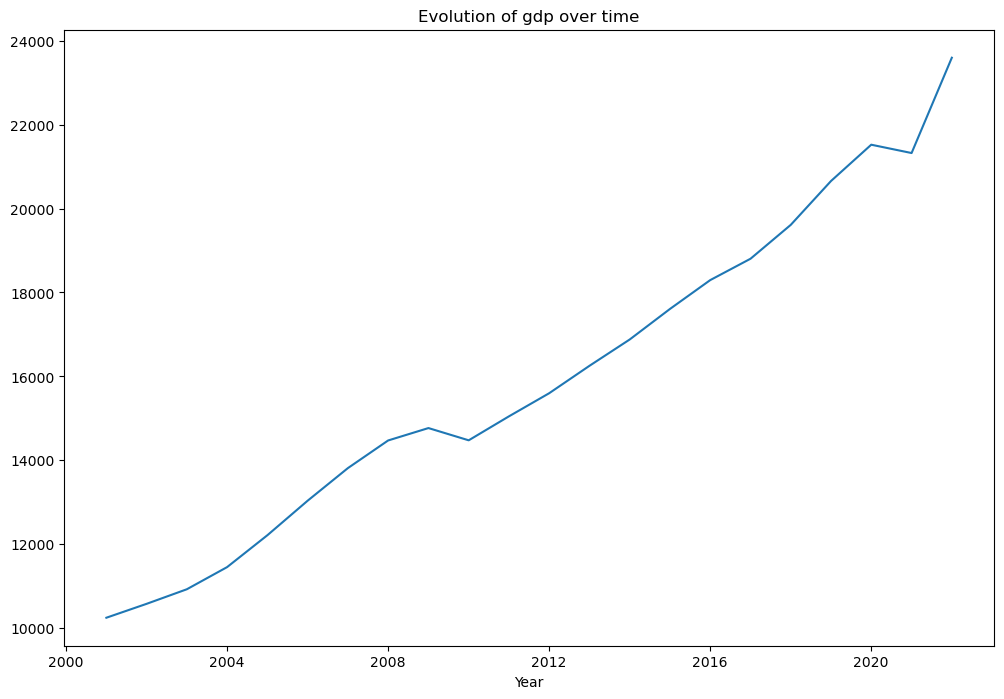

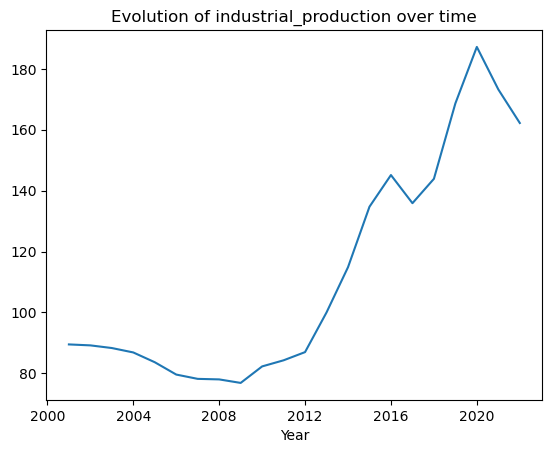

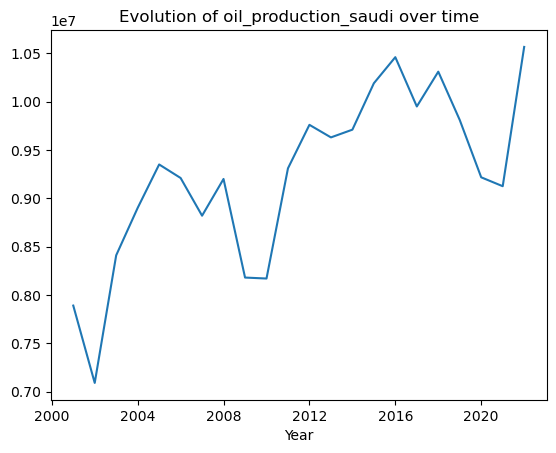

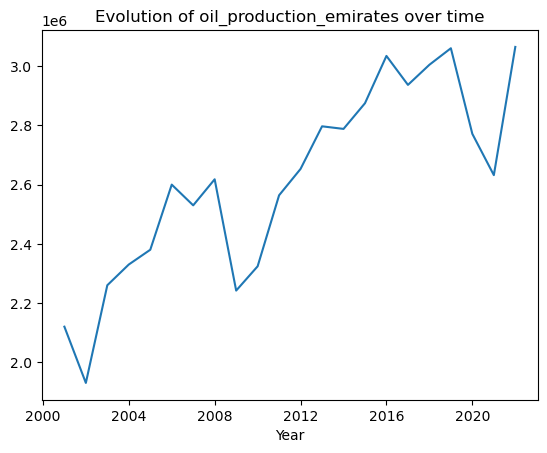

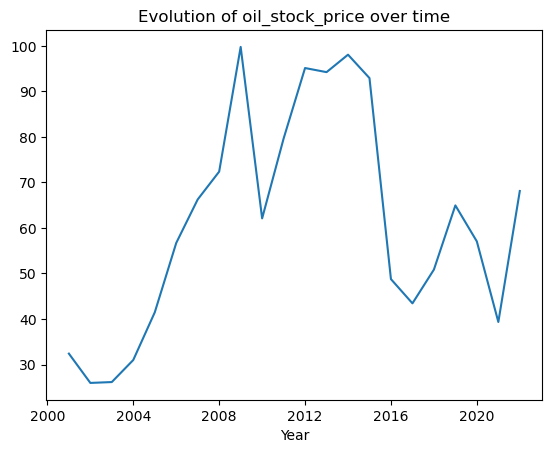

In [9]:
# Plot each column to a separate line plot graph
plt.figure(figsize=(12, 8))

for column in df.columns:
    plt.plot(df.index, df[column], label=column)
    plt.xlabel('Year')
    plt.title("Evolution of "+ column + " over time")
    plt.show()

### Compute the returns of each time series

In [10]:
# Compute the return of each column
returns_df = df.pct_change().dropna()
# Print the returns DataFrame
returns_df

,gdp,industrial_production,oil_production_saudi,oil_production_emirates,oil_stock_price
2002-01-01,0.032287,-0.003494,-0.101394,-0.089623,-0.198597
2003-01-01,0.032809,-0.009774,0.186178,0.170984,0.007320
2004-01-01,0.048251,-0.016431,0.058264,0.030973,0.185234
2005-01-01,0.066403,-0.037055,0.050562,0.021459,0.337954
2006-01-01,0.067282,-0.048429,-0.014973,0.092437,0.367392
2007-01-01,0.059542,-0.017772,-0.042345,-0.026923,0.168418
2008-01-01,0.047674,-0.002248,0.043084,0.034783,0.092220
2009-01-01,0.020425,-0.014838,-0.110870,-0.143621,0.378459
2010-01-01,-0.019756,0.070607,-0.001222,0.036574,-0.377513
2011-01-01,0.039432,0.024400,0.139535,0.103270,0.282085


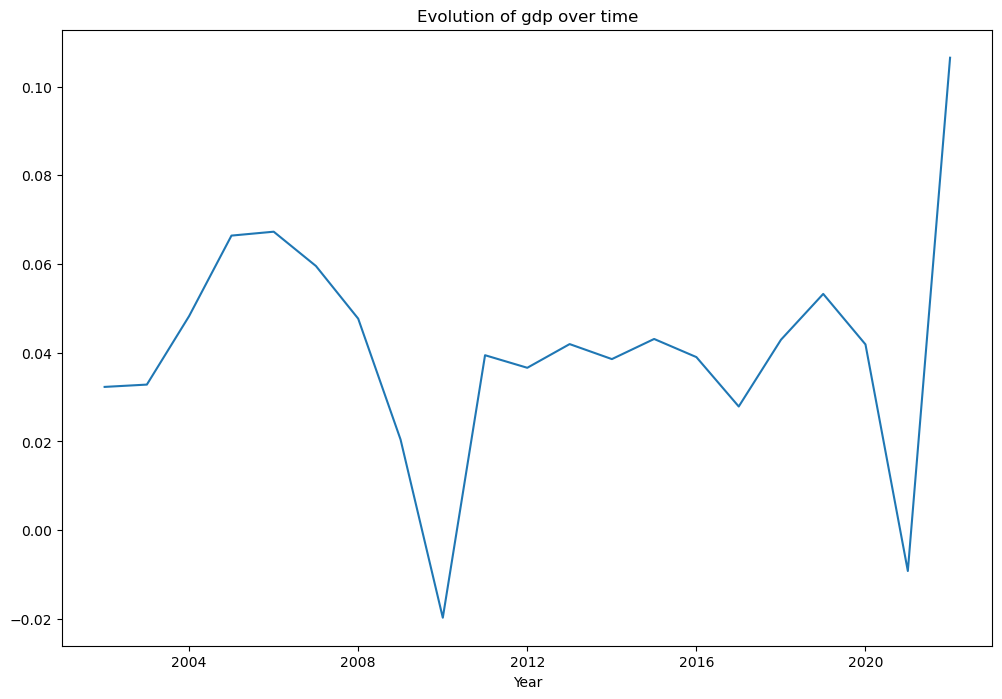

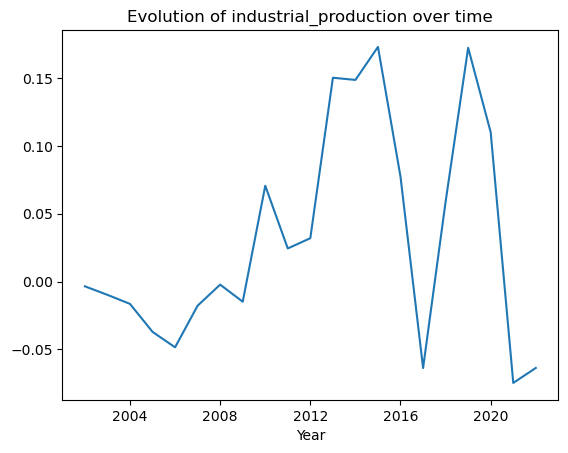

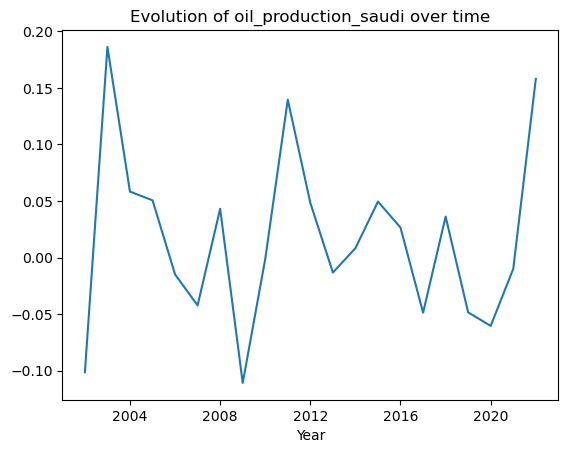

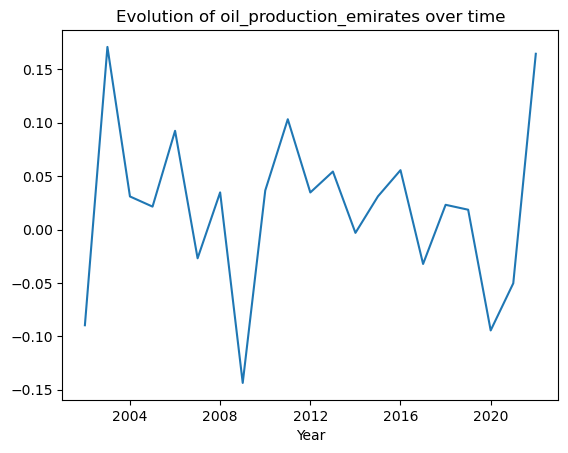

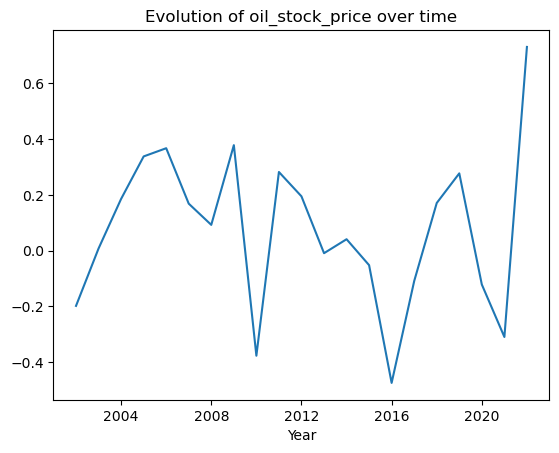

In [11]:
# Plot each column to a separate line plot graph
plt.figure(figsize=(12, 8))

for column in returns_df.columns:
    plt.plot(returns_df.index, returns_df[column], label=column)
    plt.xlabel('Year')
    plt.title("Evolution of "+ column + " over time")
    plt.show()

### Check whether after taking the return of each series, they are stationary

In [12]:
# Check for stationarity using ADF test
for column in returns_df.columns:
    result = adfuller(returns_df[column])
    print(f'ADF Test for {column}:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Is Stationary:', result[1] < 0.05)
    print("----------------------------------")
    print('\n')
    

ADF Test for gdp:
ADF Statistic: -3.696314318487574
p-value: 0.00416529623981911
Critical Values: {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125}
Is Stationary: True
----------------------------------


ADF Test for industrial_production:
ADF Statistic: -2.9795257954645376
p-value: 0.03685117790995719
Critical Values: {'1%': -3.8326031418574136, '5%': -3.0312271701414204, '10%': -2.655519584487535}
Is Stationary: True
----------------------------------


ADF Test for oil_production_saudi:
ADF Statistic: -4.178094178631945
p-value: 0.0007174737056428482
Critical Values: {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}
Is Stationary: True
----------------------------------


ADF Test for oil_production_emirates:
ADF Statistic: -3.777356210880336
p-value: 0.003147675434795737
Critical Values: {'1%': -3.8326031418574136, '5%': -3.0312271701414204, '10%': -2.655519584487535}
Is Stationary: True
----------------------------------


A

We can see that if we take the return of each time series are stationary.

### Apply simple linear regression

${{oil\_sock\_price}} = \beta_0 + \beta_1 \times {gdp} + \beta_2 \times {industrial\_production} + \beta_3 \times {oil\_production\_saudi} + \beta_4 \times {oil\_production\_emirates} + \varepsilon$

In [13]:
# Specify the dependent variable (y) and independent variables (X)
y = returns_df['oil_stock_price']
X = returns_df[['gdp', 'industrial_production', 'oil_production_saudi', 'oil_production_emirates']]
X= sm.add_constant(X)
# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        oil_stock_price   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     5.707
Date:                Sat, 25 Nov 2023   Prob (F-statistic):            0.00474
Time:                        21:49:16   Log-Likelihood:                 6.2974
No. Observations:                  21   AIC:                            -2.595
Df Residuals:                      16   BIC:                             2.628
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The R-squared value is 0.588, indicating that approximately 58.8% of the variability in the dependent variable (oil_stock_price) is explained by the independent variables.

#### Coefficients:

**const (Intercept):**

The coefficient is -0.2383, with a standard error of 0.092.
The intercept represents the estimated value of the dependent variable when all independent variables are zero. In this context, it suggests that when all independent variables are zero, the estimated oil_stock_price is -0.2383.

**gdp:**

The coefficient is 8.2095, with a standard error of 1.984.
Holding other variables constant, a one-unit increase in GDP is associated with an estimated increase of 8.2095 units in oil_stock_price. The coefficient for GDP has a p-value of 0.001. With a low p-value, GDP is highly statistically significant. This implies that changes in GDP are associated with a significant impact on oil_stock_price. Specifically, a one-unit increase in GDP is associated with a statistically significant increase in oil_stock_price.

**industrial_production:**

The coefficient is -0.6011, with a standard error of 0.586.
Holding other variables constant, a one-unit increase in industrial_production is associated with an estimated decrease of 0.6011 units in oil_stock_price. The coefficient for industrial_production has a p-value of 0.320.
The high p-value indicates that industrial_production is not statistically significant at the conventional significance level (0.05). In other words, the data do not provide enough evidence to reject the null hypothesis that the coefficient for industrial_production is zero. Changes in industrial_production may not be reliably associated with changes in oil_stock_price in this model.
 
**oil_production_saudi:**

The coefficient is 0.7317, with a standard error of 1.235.
Holding other variables constant, a one-unit increase in oil_production_saudi is associated with an estimated increase of 0.7317 units in oil_stock_price. The coefficient for oil_production_saudi has a p-value of 0.562.
Similar to industrial_production, the high p-value suggests that oil_production_saudi is not statistically significant at the conventional significance level. The data do not provide enough evidence to conclude that changes in oil_production_saudi are associated with changes in oil_stock_price in a statistically significant way.


**oil_production_emirates:**

The coefficient is -0.7138, with a standard error of 1.274.
Holding other variables constant, a one-unit increase in oil_production_emirates is associated with an estimated decrease of 0.7138 units in oil_stock_price. The coefficient for oil_production_emirates has a p-value of 0.583.
Like the previous two variables, oil_production_emirates is not statistically significant based on the p-value. The data do not provide enough evidence to reject the null hypothesis that the coefficient for oil_production_emirates is zero in the population.


### Apply Markov Switching model

We will use a 2-state Markov Switching Dynamic Regression model to try to model these ‘switches’ in variance between high and low variance regimes:
\begin{equation*}
P=
\begin{pmatrix}
  P_{00} & P_{01} \\
  P_{10} & P_{11} \\
\end{pmatrix}
\end{equation*}

The transition prob

The transition probabilities are typically represented by a transition matrix $P$ where $P_{i,j}$ is the probability of transitioning from state $i$ to state $j$

where:

* $\hat{\mu_{tj}} = \hat{\beta_{0j}} + \hat{\beta_{1j}} x_{1t}$
* \begin{equation*}
  \hat{\beta_{S}} = 
  \begin{pmatrix}
  \beta_{00} & \beta_{01} \\
  \beta_{10} & \beta_{11} \\
  \end{pmatrix}
  \end{equation*}
* $\epsilon_{tj} \approx N(0,\sigma_{j}^2)$

Notice that we have also introduced a state-specific variance. We are saying that the residual errors of the model are normally distributed around a zero mean and a variance that switches between two values depending on which state the underlying Markov process is in.

In [14]:
endog = returns_df['oil_stock_price']
exog = returns_df[['gdp', 'industrial_production', 'oil_production_saudi', 'oil_production_emirates']]

msdr_model = sm.tsa.MarkovRegression(endog=endog, k_regimes=2, trend='c', exog=exog, switching_variance=True)
msdr_model_results = msdr_model.fit(iter=1000)
msdr_model_results.summary()

C:\Users\humic\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\humic\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:        oil_stock_price   No. Observations:                   21
Model:               MarkovRegression   Log Likelihood                  17.493
Date:                Sat, 25 Nov 2023   AIC                             -6.986
Time:                        21:49:17   BIC                              7.637
Sample:                    01-01-2002   HQIC                            -3.813
                         - 01-01-2022                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2573      0.023    -11.403      0.000      -0.302      -0.213
x1             6.8127      0.434     15.680      0.000       5.961       7.664
x2            -0.6145      0.129     -4.782      0.000      -0.866      -0.363
x3             0.2329      0.272      0.856      0.392      -0.301       0.766
x4             1.2038      0.245      4.908      0.000       0.723       1.685
sigma2         0.0010      0.000      2.218      0.027       0.000       0.002
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3273      0.150     -2.182      0.029      -0.621      -0.033
x1            10.1232      3.339      3.032      0.002       3.579      16.667
x2             0.7474      1.041      0.718      0.473      -1.293       2.788
x3             4.7495      2.612      1.819      0.069      -0.369       9.868
x4            -5.8749      2.768     -2.123      0.034     -11.299      -0.450
sigma2         0.0340      0.014      2.352      0.019       0.006       0.062
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     1.202e-05        nan        nan        nan         nan         nan
p[1->0]        0.8138      0.122      6.680      0.000       0.575       1.053
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

By looking at the fitted coefficients’ values in the results, we can write the regime-specific model equations as follows:

**For regime=0 (low-variance regime)**
${{oil\_sock\_price}} = -0.2573 + 0.2573 \times {gdp} - 0.6145 \times {industrial\_production} + 0.2329 \times {oil\_production\_saudi} + 1.2038 \times {oil\_production\_emirates} + \epsilon_t$

where:

$\epsilon_t= 0.0010$

**For regime=1 (high-variance regime)**
${{oil\_sock\_price}} = -0.3273 + 10.1232 \times {gdp} + 10.1232 \times {industrial\_production} + 0.7474 \times {oil\_production\_saudi} -5.8749 \times {oil\_production\_emirates} + \epsilon_t$

where $\epsilon_t = 0.0340$


**Regime Transition Parameters:**
* p[0->0]: 1.202e-05 (Transition probability from regime 0 to regime 0)
* p[1->0]: 0.8138 (Transition probability from regime 1 to regime 0)

We can deduce :
* p[1->1]: 1-p[0->0] = 1 - 1.202e-05 = 0.99998798
* p[0->1]: 1-p[1->0] = 1 - 0.8138 = 0.186
Hence,

\begin{equation*}
P=
\begin{pmatrix}
  1.202^{-5} & 0.99998798 \\
  0.8138 & 0.186 \\
\end{pmatrix}
\end{equation*}

Overall, the transition probability from "Regime 0" to "Regime 0" is very close to zero (1.202e-05), suggesting a low probability of staying in the same regime.
The transition probability from "Regime 1" to "Regime 0" is 0.8138, indicating 
a relatively high probability of transitioning from "Regime 1" to "Regime 0."

More precisely, we can see that when stock oil price are in a low variance regime, they tend to switch to a high variance regime less than 99% of the time, while if the stock oil price is in a high variance regime, it tends to switch back to a low variance regime with roughly 81% probability. 

#### Regime-Specific Coefficients:

There are two regimes, each with its set of coefficients for the constant and predictors. The regimes are denoted as "Regime 0" and "Regime 1."
For example, in "Regime 0," the coefficient for the first predictor (x1) is 6.8127, while in "Regime 1," the coefficient for the same predictor is 10.1232.

**Variance of the Error Term ($\sigma_2$):**

The variance of the error term differs between regimes, being 0.0010 in "Regime 0" and 0.0340 in "Regime 1."

**Significance of Parameters:**

The statistical significance of each coefficient and transition parameter is indicated by the z-test and associated p-values. Low p-values (typically < 0.05) suggest significance.

* **Regime 0**
    * Regime 0 appears to have significant coefficients for const, gdp, industrial_production, and oil_production_emirates, suggesting that these variables are important predictors of the dependent variable in this regime.

    * The coefficient for oil_production_saudi is not statistically significant in Regime 0 (p-value > 0.05), indicating that it may not be a significant predictor in this particular regime.

    * The variance of the error term (sigma2) is statistically significant, indicating that the estimated volatility of the residuals in Regime 0 is different from zero.

* **Regime 1**

    * In Regime 1, the intercept, coefficients for gdp, and oil_production_saudi are statistically significant, suggesting that these variables are important predictors of the dependent variable in this regime.

    * The coefficients for industrial_production and oil_production_emirates are not statistically significant in Regime 1 (p-value > 0.05), indicating that they may not be significant predictors in this particular regime.

    * The variance of the error term (sigma2) is statistically significant, suggesting that the estimated volatility of the residuals in Regime 1 is different from zero.

**Regime Interpretation:**

The two regimes capture different states or patterns in the data. The transition parameters provide insights into the likelihood of transitioning between these states.

Conclusion:
This type of model is useful for capturing and modeling changes in the behavior of the variable "oil_stock_price" over time, allowing for different regimes with distinct sets of coefficients. Interpretation should involve examining the regime-specific coefficients, transition probabilities, and variance components to understand the dynamics of the system. Additionally, assessing the goodness of fit and conducting diagnostic checks is important for validating the model's 

In [15]:
msdr_model_results.smoothed_marginal_probabilities

,0,1
2002-01-01,9.728765e-01,0.027123
2003-01-01,1.032378e-11,1.000000
2004-01-01,9.722675e-01,0.027732
2005-01-01,3.569336e-06,0.999996
2006-01-01,9.999735e-01,0.000026
2007-01-01,8.398264e-06,0.999992
2008-01-01,9.897269e-01,0.010273
2009-01-01,6.225666e-107,1.000000
2010-01-01,9.981182e-01,0.001882
2011-01-01,7.077952e-05,0.999929


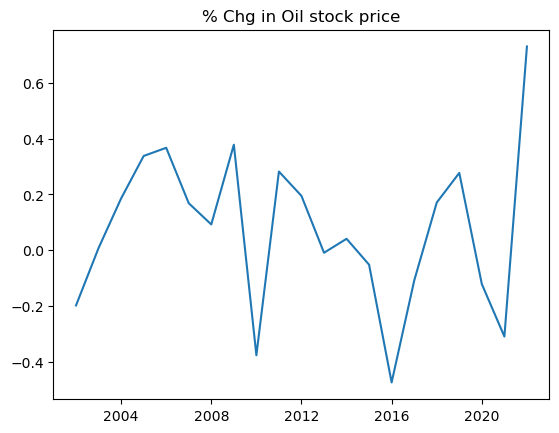

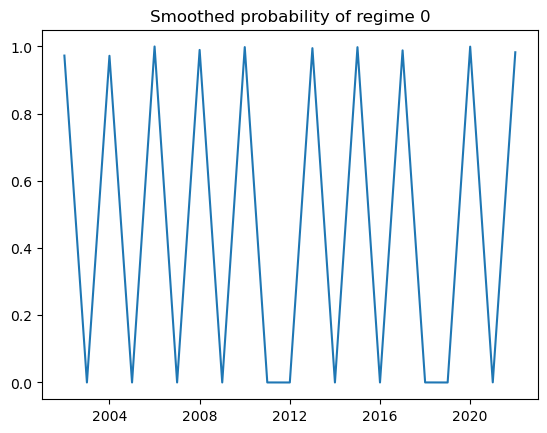

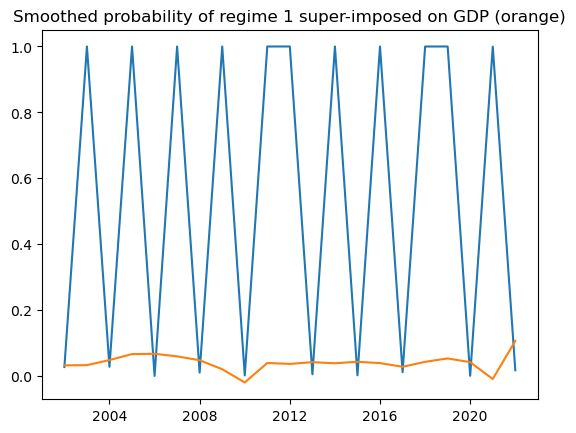

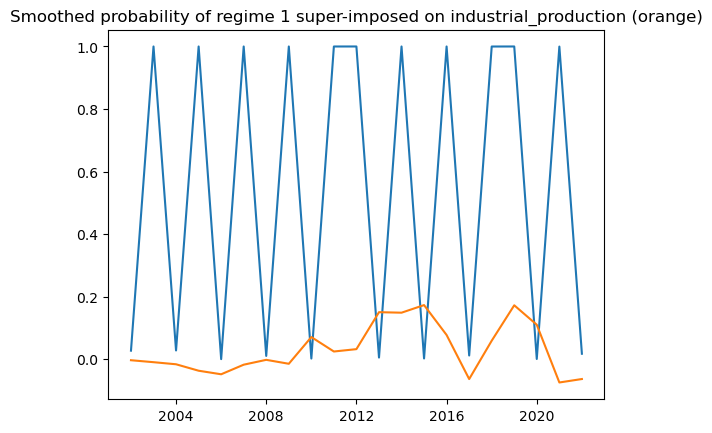

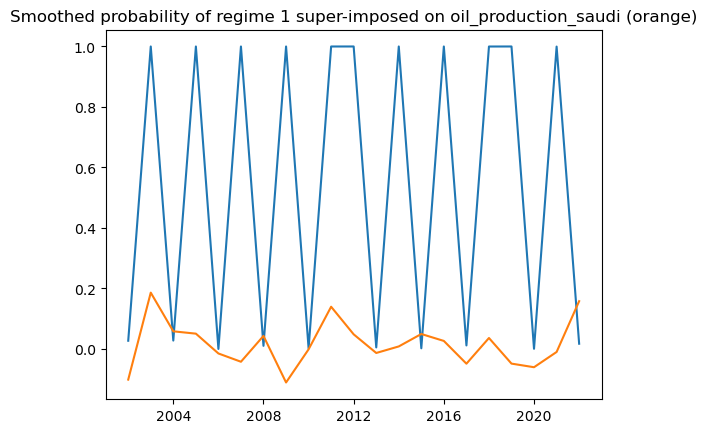

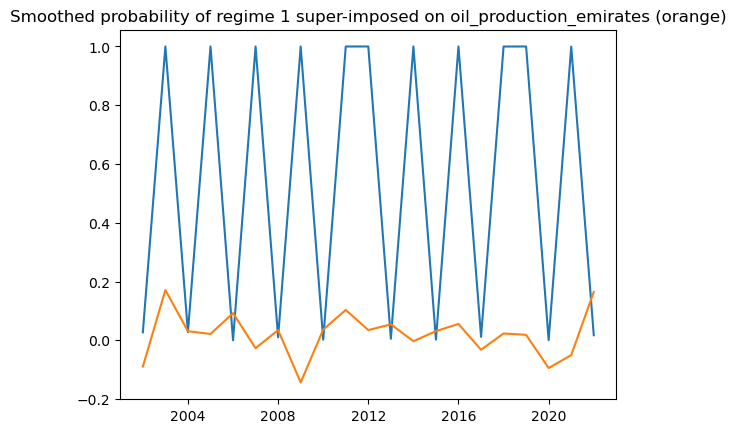

In [17]:
plt.plot(returns_df.index, returns_df['oil_stock_price'])
plt.title('% Chg in Oil stock price')
plt.show()
 
plt.plot(returns_df.index, msdr_model_results.smoothed_marginal_probabilities[0])
plt.title('Smoothed probability of regime 0')
plt.show() 
    
plt.plot(returns_df.index, msdr_model_results.smoothed_marginal_probabilities[1])
plt.plot(returns_df.index, returns_df['gdp'])
plt.title('Smoothed probability of regime 1 super-imposed on GDP (orange)')
plt.show()

plt.plot(returns_df.index, msdr_model_results.smoothed_marginal_probabilities[1])
plt.plot(returns_df.index, returns_df['industrial_production'])
plt.title('Smoothed probability of regime 1 super-imposed on industrial_production (orange)')
plt.show()

plt.plot(returns_df.index, msdr_model_results.smoothed_marginal_probabilities[1])
plt.plot(returns_df.index, returns_df['oil_production_saudi'])
plt.title('Smoothed probability of regime 1 super-imposed on oil_production_saudi (orange)')
plt.show()

plt.plot(returns_df.index, msdr_model_results.smoothed_marginal_probabilities[1])
plt.plot(returns_df.index, returns_df['oil_production_emirates'])
plt.title('Smoothed probability of regime 1 super-imposed on oil_production_emirates (orange)')
plt.show()